<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction:-Split-Test-Analysis" data-toc-modified-id="Introduction:-Split-Test-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Split Test Analysis</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#What's-your-interpretation-of-these-results?" data-toc-modified-id="What's-your-interpretation-of-these-results?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What's your interpretation of these results?</a></span></li><li><span><a href="#Calculating-A/B-Test-Sample-Size" data-toc-modified-id="Calculating-A/B-Test-Sample-Size-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Calculating A/B Test Sample Size</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Determining-Variation-3-rate-with-Bayes-analysis" data-toc-modified-id="Determining-Variation-3-rate-with-Bayes-analysis-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Determining Variation 3 rate with Bayes analysis</a></span></li><li><span><a href="#Hierarchical-Model:--A/B-Test" data-toc-modified-id="Hierarchical-Model:--A/B-Test-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Hierarchical Model:  A/B Test</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Introduction: Split Test Analysis

Often companies demand quick and effective methods for conducting market research. This type of research is necessary for testing customer reactions to visuals or campaigns. In this example, four treatments were applied to a website. The purpose was to increase sales quotes sent from clients to customers—conversion rates. This notebook analyzes which treatments generate the most activity. The activity is quantified with Bayesian A/B testing. Bayes inference has the advantage of generating credible intervals for each rate. Two sets of rates are calculated. One is considered the empirical rate, calculated by taking the ratio of views to conversions. The second rate, 'True rate', is calculated by pooling the data with a Bayes hierarchical model. When looking at the posterior distributions, the probability that Variation 3 gets more quotes than the Baseline is 98%. 

In summary, the data looks promising; however, the sample size needed for statistical significance is closer to 1000 views per variation. Given the number of views (approximately 600 per variation), a stronger rate of 9.66% is necessary for statistical significance. This discrepancy is reflected in the credible intervals for Variation 3 (p_3), [0.064, 0.108]. With more data, this type of analysis can effectively inform a business decision. 

In [77]:
import pandas as pd
import seaborn as sns
import numpy as np
from pymc3 import  *
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
%matplotlib inline

# Analysis

## Loading data

In [78]:
df = pd.read_csv( '../data/data.csv')
df.head()

,Bucket,Quotes,Views
0,Baseline,32,595
1,Variation 1,30,599
2,Variation 2,18,622
3,Variation 3,51,606
4,Variation 4,38,578


## What's your interpretation of these results? 

It's difficult to analyze the data with so much of it missing. More informed suggestions could be made by looking at the granular data. For example, do certain cities or categories have greater rates of quotes sent? If so then, then A/B tests should be done against category-base-quote rate versus the variation in that segment. 

Without these granular data, we can at least look at the quote rate per variation. 

In [79]:
df['Empirical rate %'] = df.Quotes / df.Views *100    #divides Quotes column by Views 
df['Empirical rate %'] = df['Empirical rate %'] .round(2)            #rounds to two decimal places 
df.set_index("Bucket", inplace = True )     #changes the index to 'Bucket'
df

,Quotes,Views,Empirical rate %
Bucket,,,
Baseline,32,595,5.38
Variation 1,30,599,5.01
Variation 2,18,622,2.89
Variation 3,51,606,8.42
Variation 4,38,578,6.57


## Calculating A/B Test Sample Size
We can utilize  statistical significance in two ways: 
1. To determine the number of sample size needed to have statistical significance for conversion rates reported
2. To determine the statistical significance possible with the number of views we currently have. 

Given the conversion rate probabilities 5.45% and 8.47% we would need at least 1000 views per variation. Since we only have about 600 views per variation, at best we can claim, a wider margin, of 5.45% and 10%. But the data doesn't support that claim.  

In [80]:
# Function for calculating sample size for each treatment
def sample_size(p1, p2, sig):
    '''Function to calculate sample size for each treatment. 
    p1 is probability in one group. p2 is the probability for another group. sig is significance level. p is power of test '''

    es = sms.proportion_effectsize(p1, p2)
    return int(sms.NormalIndPower().solve_power(es, power=0.8, alpha=sig, ratio=1))

In [81]:
# Sample size needed to have statistical significance
sample_size(.0545, .0847, .05)

1101

In [82]:
# What statistical significance would be satisfied with current sample size
sample_size(.0545, .0966, .05)

606

## Models

Looking at the 'Empirical rate %' column we see that Variation 3 performed the best with 8.42%, followed by Variation 4 with 6.57%. The other two variations performed below the Baseline, 5.38%.

If we wanted to know about the confidence interval in the rates, we would invoke Bayesian statistics. By performing Bayesian statistics, we are interested in modeling the posterior distribution: Prob(True Quote Rate | Data) ~ Prob(Data|True Quote Rate)·Prob(True Quote Rate). We do so by treating the data as a Bernoulli distribution, assuming quotes are independent. For a Bernoulli distribution, we could say a quote sent is a 'success' or 1; a quote not sent, 0. In order to do so, we'll first need to generate binomial data for the variations. 

In [86]:
#Generate list data for variations 
def simulated_data(data_name):  #Counts Quotes as ones and generates zeros for rest of list 
    data = [1]*df.get_value(data_name, 'Quotes') + [0]*(df.get_value(data_name, 'Views') - df.get_value(data_name, 'Quotes'))    
    return data 

In [87]:
# Generated data
base = simulated_data("Baseline")
var1 = simulated_data("Variation 1")
var2 = simulated_data("Variation 2")
var3 = simulated_data("Variation 3")
var4 = simulated_data("Variation 4")

/Users/cristian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


In [88]:
#First 40 data points for Variation 1, notice zeros after 30 ones
print("Data from var1: ", var1[:40], "...")  

Data from var1:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ...


### Determining Variation 3 rate with Bayes analysis 

Below we see, Bayes analysis yields a Variation 3 rate of 8.6%, similar to the Empirical data; however, now we have the 95% confidence interval (CI)  (6.4%, 10.8%). More data would tighten up the CI.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:07<00:00, 771.41it/s]



p_b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.055            0.009            0.000            [0.038, 0.074]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.038          0.049          0.055          0.061          0.075


p_3:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.086            0.011            0.000            [0.064, 0.108]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.065          0.078          0.085          0.093          0.109



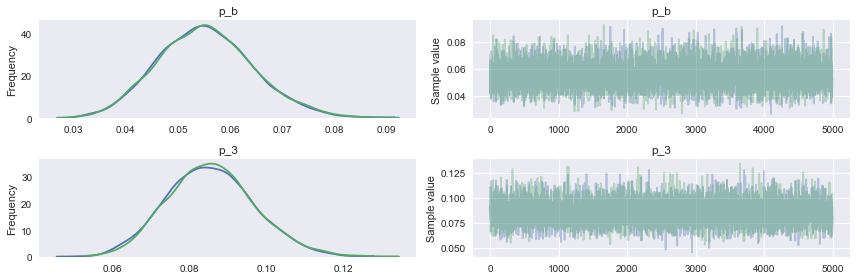

In [89]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    p_b = Uniform("p_b", 0, 1)  #assume we know nothing about the prior Baseline probability 
    p_3 = Uniform("p_3", 0, 1)  #assume we know nothing about the prior Variation 3 probability
    
    # Define likelihood
    obs_b = Bernoulli('obs_b', p = p_b , observed=base)  #model data as Bernoulli with prob. p_b as parameter 
    obs_3 = Bernoulli('obs_3', p = p_3 , observed=var3)  #model data as Bernoulli with prob. p_3 as parameter 
    
    # Inference
    trace = sample(5000, tune = 500, njobs =2) # draw 5 posterior samples
    
    traceplot(trace) #plot traces
    summary(trace) #plot results 


Now, let's examine the posterior of the delta distribution below. The orange line at x = 0, represents where the difference between the two distributions is 0. We can see that the majority of the distribution is above delta = 0.  This means most of the points sampled from Variation 3's distribution are larger than those sampled from the Baseline's distribution, implying Variation 3 is likely better than Baseline rates. 

To get more quantitative results, we can compute the probability that Variation 3 gets more quotes than Baseline. This can be done with any variation permutation. 

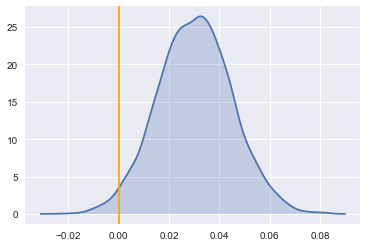

In [91]:
delta_distribution = trace['p_3'] - trace['p_b']  #subtracts the Variation from Baseline 

sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'orange');

In [185]:
print ( "Probability that Baseline gets MORE quotes than Variation 3: %0.3f" % (delta_distribution < 0).mean() )
print ( "Probability that Baseline gets LESS quotes than site Variation3: %0.3f" % (delta_distribution > 0).mean() )

Probability that Baseline gets MORE quotes than Variation 3: 0.020
Probability that Baseline gets LESS quotes than site Variation3: 0.980


### Hierarchical Model:  A/B Test  

If we have two samples sizes, for example, Baseline has size a and Variation 3, size b. This analysis incorporates ideas about the logit to get desired mathematical properties when sampling for a and b.

In [92]:
import pymc

@pymc.stochastic(dtype=np.float64)
def hyperpriors(value=[1.0, 1.0]):
    a, b = value[0], value[1]
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = hyperpriors[0]
b = hyperpriors[1]

In [93]:
# The hidden, true rate for each website.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# The observed values
trials = df.Views.as_matrix() #Passes array of values 
successes = df.Quotes.as_matrix() #Passes array 
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1M samples, and throw out the first 500k
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 218.4 sec

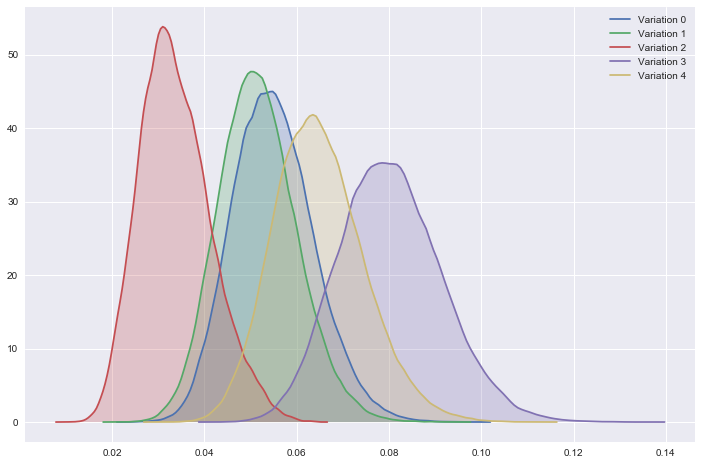

In [94]:
plt.figure(figsize=(12,8))
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Variation %s" % chr(48+i))

In [95]:
# save means to list 
true_rate = []
for i in range(5):
    true_rate.append( mcmc.trace('true_rates')[:][:,i].mean() ) 
    
# save means to df
df['True rate %']  = pd.DataFrame({'True rate %': true_rate}, index=df.index)
df['True rate %'] = (df['True rate %']*100).round(2)

In [96]:
df

,Quotes,Views,Empirical rate %,True rate %
Bucket,,,,
Baseline,32,595,5.38,5.50
Variation 1,30,599,5.01,5.16
Variation 2,18,622,2.89,3.37
Variation 3,51,606,8.42,8.03
Variation 4,38,578,6.57,6.48


 # Summary 
 
Calculating A/B Test Sample Size From the analysis 'Variation 3' is the clear winner, with a 98% probability of receiving more quotes than Baseline. However, the number of views need to be doubled in order to reach statistical significance. Given the number of views (approximately 600 per variation), a stronger rate of 9.66% is necessary for statistical significance. 

If you were trying to increase quotes in specific categories or cities, then over these specific categories and cities a similar analysis could be run. 

Other metrics that would have been of use: What is the conversion rate for quotes sent? Armed with conversion rates an expected return could be calculated. That would be an important metric to convey the return on investment. 